In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

# Fct Sigmo + Logit

In [2]:
t_hat = -np.inf
t_min, t_max = 0,10

t = t_min + (t_max-t_min)*(1/(1+np.exp(-t_hat)))
print('t=%s'%t)

x = (t-t_min)/(t_max-t_min)
logit = np.log(x/(1-x))
print('t_hat=%s, logit=%s --> %s'%(t_hat, logit, logit==t_hat))

#---------------------------------------------------------------
print('\n', '-'*50, sep='')
t = 15
t_min, t_max = 13, 80

x = (t-t_min)/(t_max-t_min)
t_hat = np.log(x/(1-x))
print('t_hat=%s'%t_hat)

sigmo = t_min + (t_max-t_min)*(1/(1+np.exp(-t_hat)))
print('t=%s, sigmo=%s --> %s'%(t, sigmo, sigmo==t))

t=0.0
t_hat=-inf, logit=-inf --> True

--------------------------------------------------
t_hat=-3.481240089335692
t=15, sigmo=15.0 --> True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


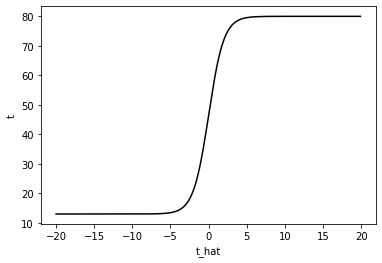

In [3]:
t_min, t_max = 13, 80
t_hat = np.arange(-20, 20, 0.1)
t = t_min + (t_max-t_min)*(1/(1+np.exp(-t_hat)))

plt.plot(t_hat, t, 'k')
plt.xlabel('t_hat')
plt.ylabel('t');

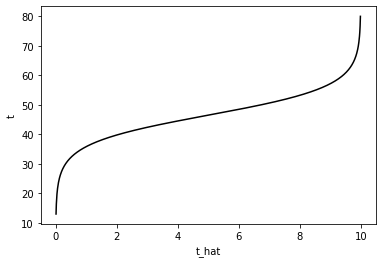

In [4]:
t_min, t_max = 13, 80
max_t = 10

t_hat = np.arange(0.01, max_t, 0.01)

x = t_hat/max_t #(t_hat-t_min)/(t_max-t_min)
x_min, x_max = 0.01/max_t, (max_t-0.01)/max_t

t  = (np.log(x/(1-x)))
t /= (np.log(x_max/(1-x_max))-np.log(x_min/(1-x_min)))
t *= (t_max-t_min)
t += (t_max-t_min)/2 + t_min

plt.plot(t_hat, t, 'k')
plt.xlabel('t_hat')
plt.ylabel('t');

# fct_velocity avec changement tau

In [5]:
def fct_velocity_tau(x, dir_target, start_anti, a_anti, latency, tau_hat, steady_state, do_whitening) :


    tau_min, tau_max = 13., 80.
    #tau = tau_min + (tau_max-tau_min)*(1/(1+np.exp(-tau_hat)))
    
    max_t = 100
    x_, x_min, x_max = tau_hat/max_t, 0.01/max_t, (max_t-0.01)/max_t
    tau = ( (np.log(x_/(1-x_))/(np.log(x_max/(1-x_max))-np.log(x_min/(1-x_min)))) * (tau_max-tau_min) ) + ((tau_max-tau_min)/2) + tau_min
    
    
    if start_anti >= latency :
        velocity = None

    else :
        a_anti = a_anti/1000 # to switch from sec to ms
        time = x
        velocity = []
        y = ((latency-1)-start_anti)*a_anti
        maxi = (dir_target*steady_state) - y

        for t in range(len(time)) :

            if time[t] < start_anti :
                velocity.append(0)
            else :
                if time[t] < latency :
                    velocity.append((time[t]-start_anti)*a_anti)
                else :
                    velocity.append(maxi*(1-np.exp(-1/tau*(time[t]-latency)))+y)

        if do_whitening is True : velocity = whitening(velocity)

    return velocity

# Fit avec changement tau

In [6]:
def test_None(var, value) :

    None_or_nan = False

    if type(var) in [float, np.float64, np.float32, np.float16] :
        if np.isnan(var) :
            None_or_nan = True
            return value

    elif var is None :
        None_or_nan = True
        return value

    if None_or_nan is False :
        return var

In [7]:
def generation_param_fit(dir_target=None,
                         trackertime=None, TargetOn=None, StimulusOf=None, saccades=None,
                         value_latency=None, value_steady_state=None, value_anti=None,
                         before_sacc=5, after_sacc=15, fit_anticipation=True, **opt) :

    t_0 = trackertime[0]

    value_latency      = test_None(value_latency, value=TargetOn-t_0+100)
    value_steady_state = test_None(value_steady_state, value=15.)
    
    if fit_anticipation is True :
        value_anti  = test_None(value_anti, value=0.)
        vary_anti, vary_start_anti = True, 'vary'
    else :
        value_anti = 0
        vary_anti, vary_start_anti = False, False

    #----------------------------------------------
    max_latency = []
    for s in range(len(saccades)) :
        if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) : max_latency.append((saccades[s][0]-t_0))
    if max_latency == [] :                              max_latency.append(len(trackertime))
    max_latency = max_latency[0]

    if value_latency >= max_latency-50 : value_latency = max_latency-150
    if value_latency > 250 :             value_latency = TargetOn-t_0+100
    
    #----------------------------------------------
    param_fit=[{'name':'steady_state', 'value':value_steady_state, 'min':5.,                 'max':40.,             'vary':True  },
               {'name':'dir_target',   'value':dir_target,         'min':None,               'max':None,            'vary':False },
               {'name':'a_anti',       'value':value_anti,         'min':-40.,               'max':40.,             'vary':vary_anti  },
               {'name':'latency',      'value':value_latency,      'min':TargetOn-t_0+75,    'max':max_latency,     'vary':True  },
               {'name':'start_anti',   'value':TargetOn-t_0-100,   'min':StimulusOf-t_0-200, 'max':TargetOn-t_0+75, 'vary':vary_start_anti},
               {'name':'tau_hat',      'value':2.000e-02,          'min':0.01,               'max':100,             'vary':'vary'}]

    inde_vars={'x':np.arange(len(trackertime))}

    return param_fit, inde_vars

In [8]:
def Fit_trial_tau(data_trial, data_x=None, dir_target=None,
              trackertime=None, TargetOn=None, StimulusOf=None, saccades=None,
              time_sup=280, step_fit=2, do_whitening=False,
              value_latency=None, value_steady_state=15., value_anti=0.,
              before_sacc=5, after_sacc=15, fit_anticipation=True, **opt) :


    from lmfit import  Model, Parameters

    #-----------------------------------------------------------------------------
    trackertime = test_None(trackertime, value=np.arange(len(data_trial)))
    
    #-----------------------------------------------------------------------------
    if   step_fit == 1 : vary = True
    elif step_fit == 2 : vary = False

    
    if time_sup is not None :
        data_trial = data_trial[:-time_sup]
        trackertime = trackertime[:-time_sup]
        
    if do_whitening :
        for x in range(len(data_trial)) :
            if np.isnan(data_trial[x]) :
                if x == 0 : data_trial[x] = 0
                else :      data_trial[x] = data_trial[x-1]

        data_trial = whitening(data_trial)
    
    opt = {'dir_target':dir_target,       'trackertime':trackertime,
           'TargetOn':TargetOn,           'StimulusOf':StimulusOf, 'saccades':saccades,
           'value_latency':value_latency, 'value_steady_state':value_steady_state, 'value_anti':value_anti,
           'before_sacc':before_sacc,     'after_sacc':after_sacc, 'fit_anticipation':fit_anticipation}

    param_fit, inde_vars = generation_param_fit(**opt)
    
    equation = fct_velocity_tau

    params = Parameters()
    model = Model(equation, independent_vars=inde_vars.keys())

    for num_par in range(len(param_fit)) :

        if 'expr' in param_fit[num_par].keys() :
            params.add(param_fit[num_par]['name'], expr=param_fit[num_par]['expr'])
        else :
            if param_fit[num_par]['vary'] == 'vary' : var = vary
            else :                                    var = param_fit[num_par]['vary']
            params.add(param_fit[num_par]['name'],
                       value=param_fit[num_par]['value'],
                       min=param_fit[num_par]['min'],
                       max=param_fit[num_par]['max'],
                       vary=var)

    params.add('do_whitening', value=do_whitening, vary=False)

    if step_fit == 1 :

        result_deg = model.fit(data_trial, params, nan_policy='omit', **inde_vars)

    elif step_fit == 2 :
        
        out = model.fit(data_trial, params, nan_policy='omit', **inde_vars)
        
        # make the other parameters vary now
        for num_par in range(len(param_fit)) :
            if 'vary' in param_fit[num_par].keys() :
                if param_fit[num_par]['vary'] == 'vary' :
                    out.params[param_fit[num_par]['name']].set(vary=True)
        
        result_deg = model.fit(data_trial, out.params, method='nelder', nan_policy='omit', **inde_vars)

    return result_deg


# Test New Fit

In [9]:
sujets = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
times = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [10]:
def test_fit(sujet, trials):
    
    with open('data/enregistrement_%s_%s.pkl'%(sujets[sujet], times[sujet]), 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
    datafile = 'data/enregistrement_%s_%s.asc'%(sujets[sujet], times[sujet])

    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    data = read_edf(datafile, 'TRIALID')

    result, result_new = [], []
    for t, trial in enumerate(trials) :
        #= 1 ===============================================================================================
        if t==0:
            print('trial:%s'%(trial))
            Plot.plot_fit(data, trials=trial, fig_width=30)

        arg = A.arg(data[trial], trial=trial, block=0)
        velocity = A.velocity_NAN(**arg)
        old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)


        rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state,
                             value_anti=old_anti, **arg)

        rere = rere.values
        for k in ['latency', 'start_anti'] : rere[k] = rere[k] - (arg.TargetOn-arg.t_0)
        result.append(rere)
        
        #= 2 ===============================================================================================
        rere = Fit_trial_tau(velocity, value_latency=old_latency, value_steady_state=old_steady_state,
                             value_anti=old_anti, **arg)
        rere = rere.values
        
        if t==0:
            fit = fct_velocity_tau(arg.trackertime[:-280]-arg.t_0, **rere)
            plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, c='k')
            plt.show()

        for k in ['latency', 'start_anti'] : rere[k] = rere[k] - (arg.TargetOn-arg.t_0)
        result_new.append(rere)
        
    return(result, result_new)

AM
trial:109


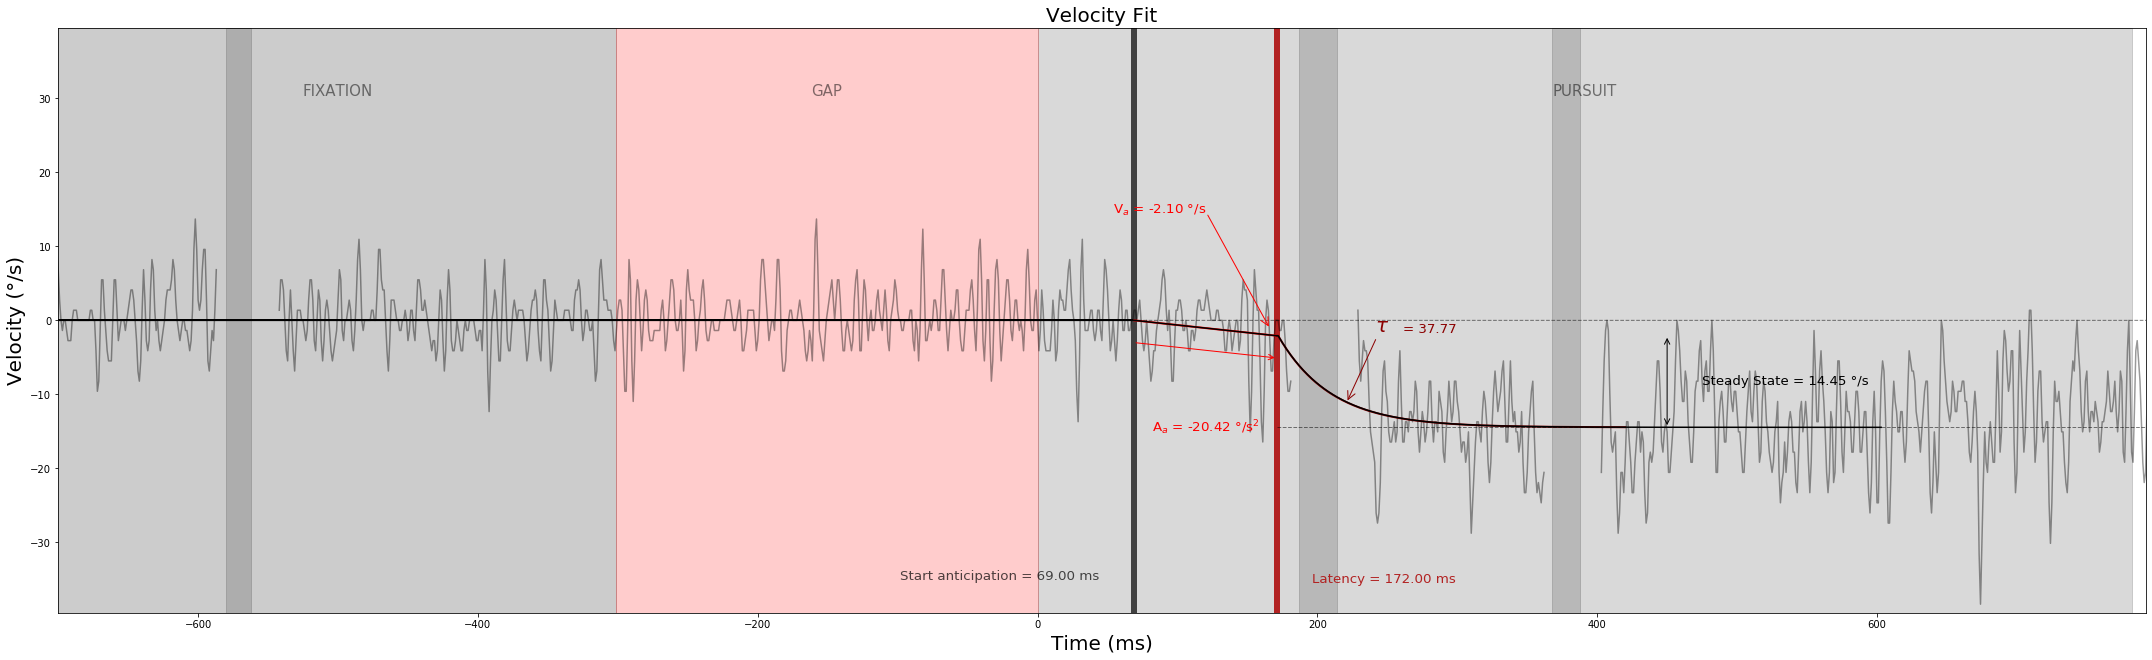

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

BMC
trial:87


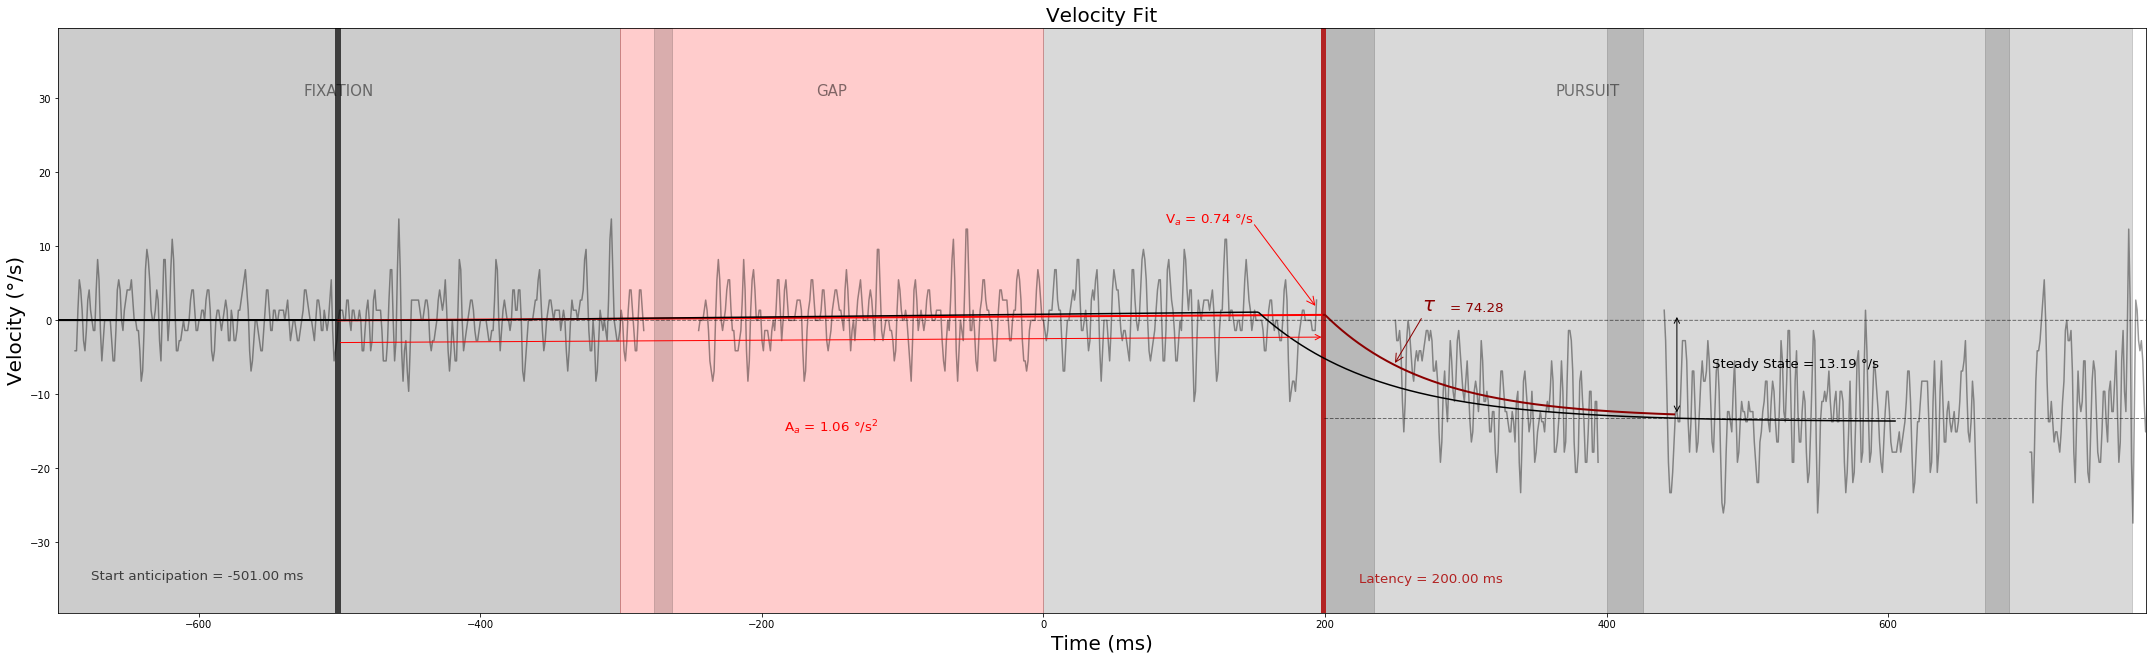

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

CS
trial:2


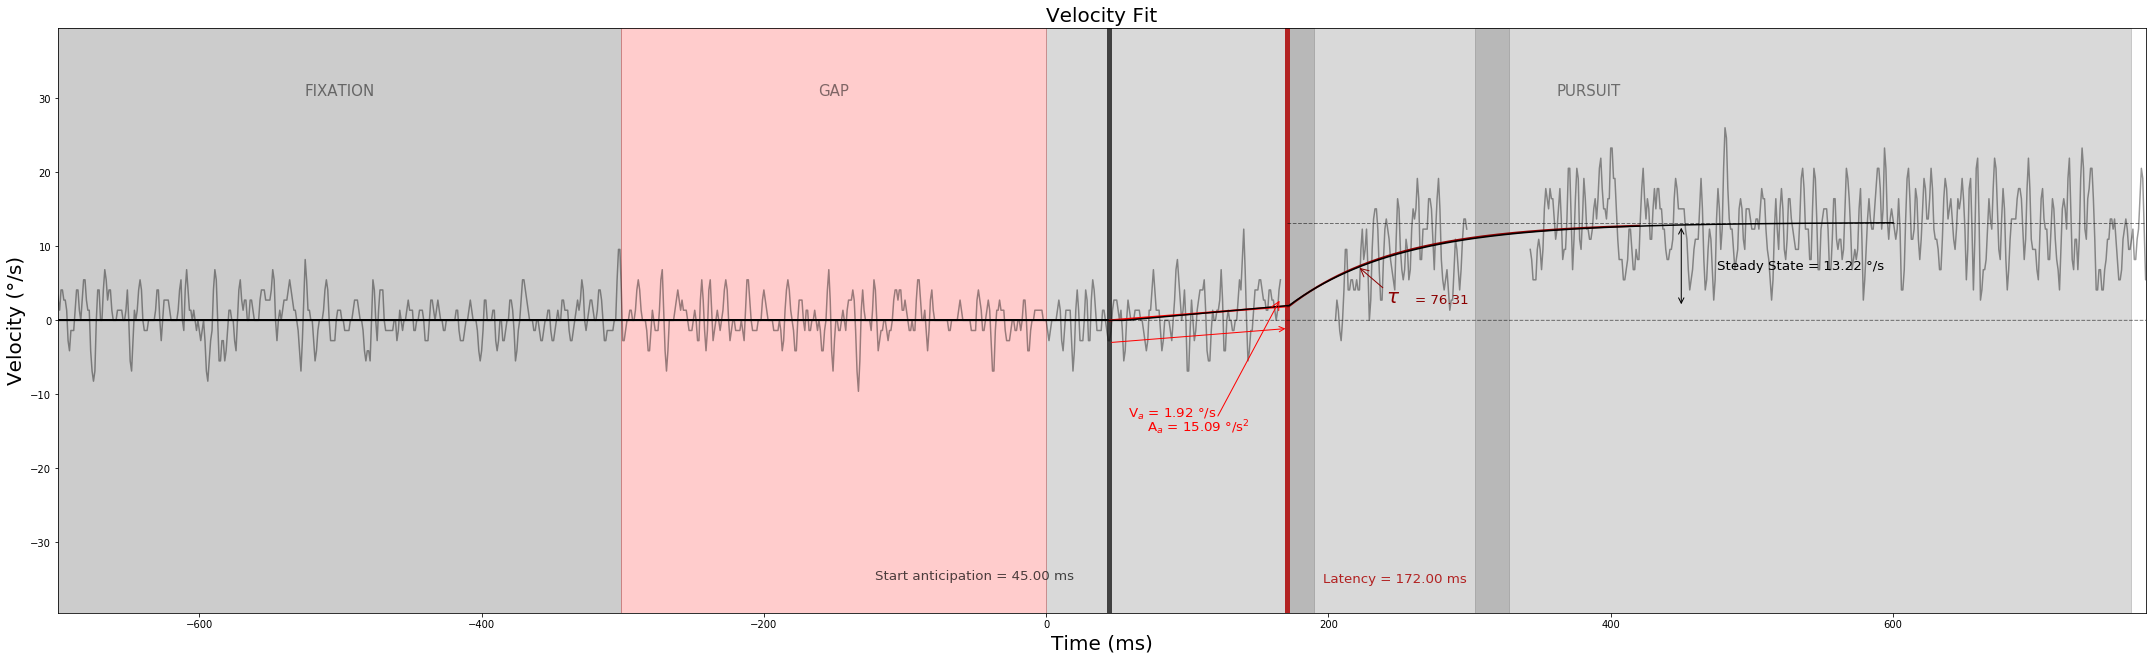

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

DC
trial:173


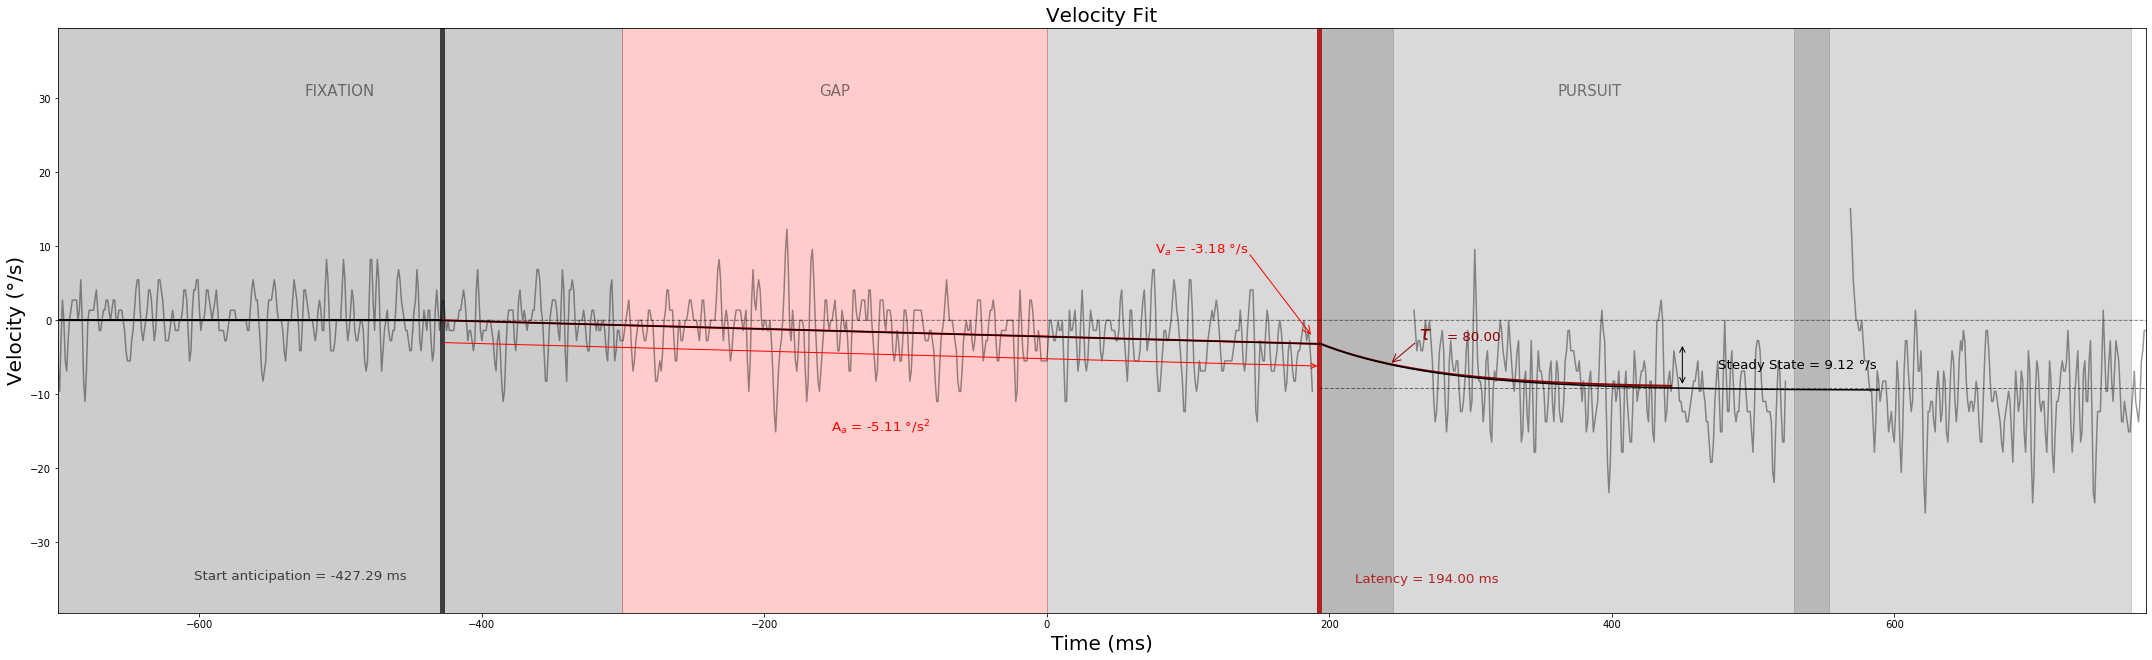

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

FM
trial:34


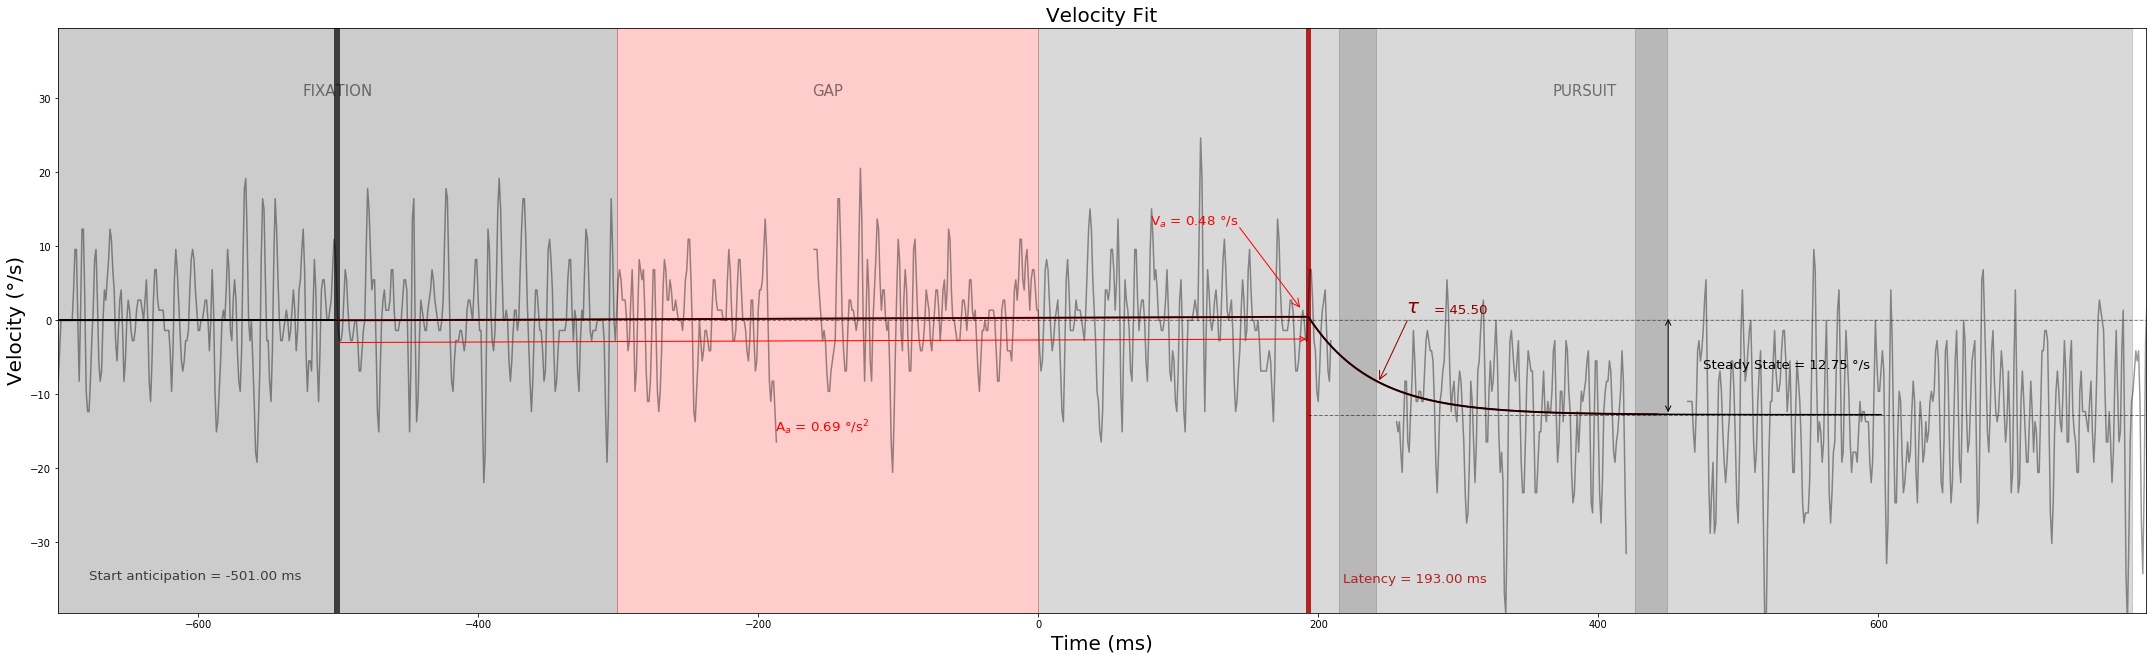

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

IP
trial:86


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


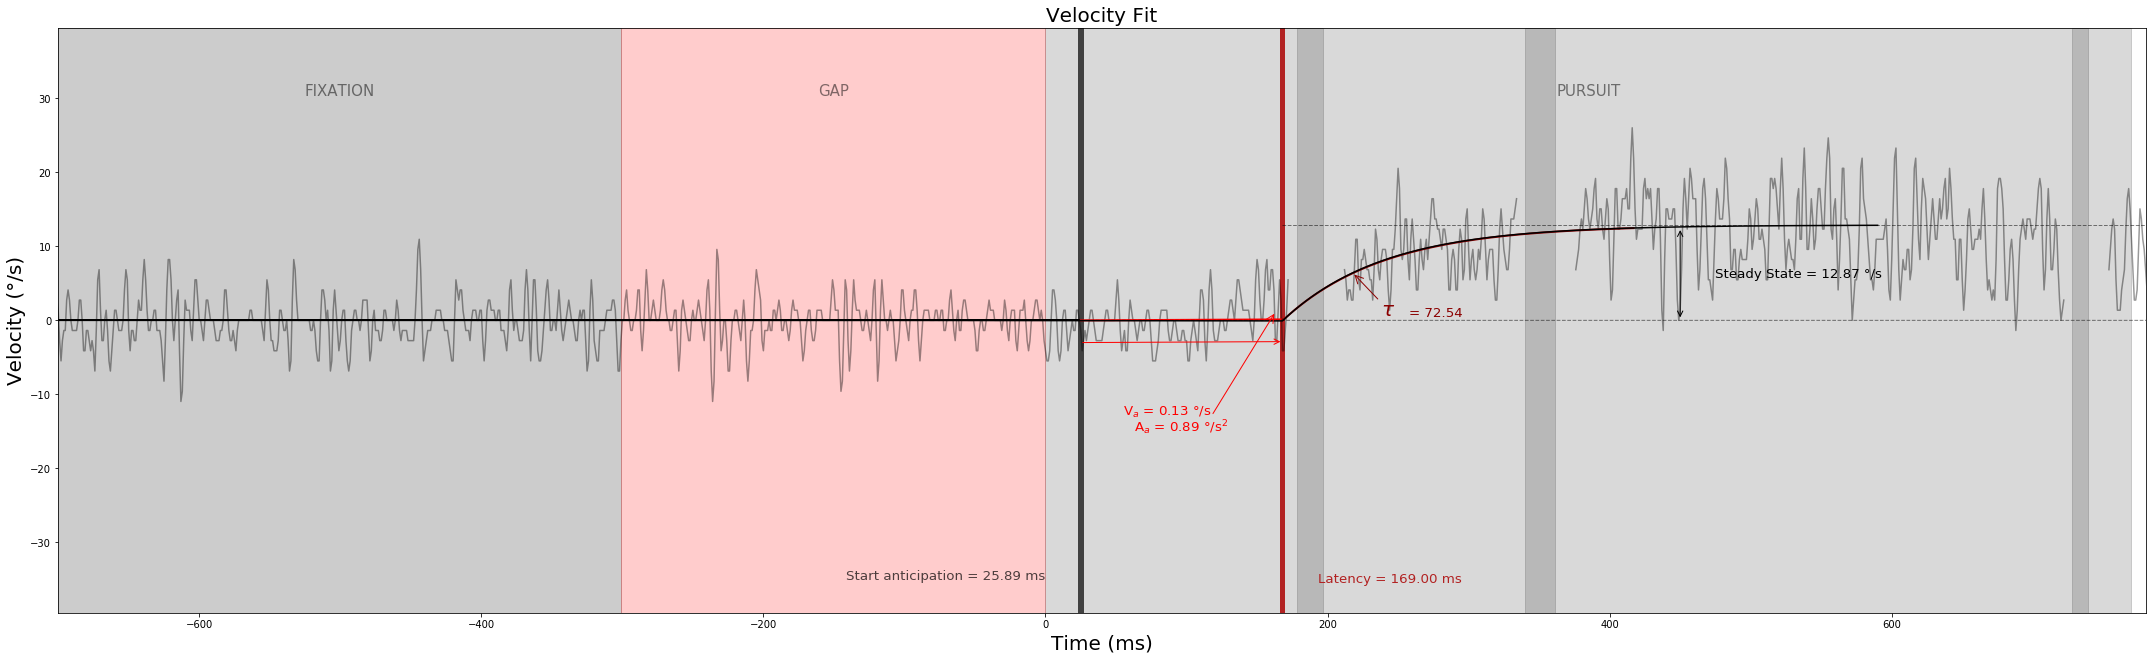

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

LB
trial:158


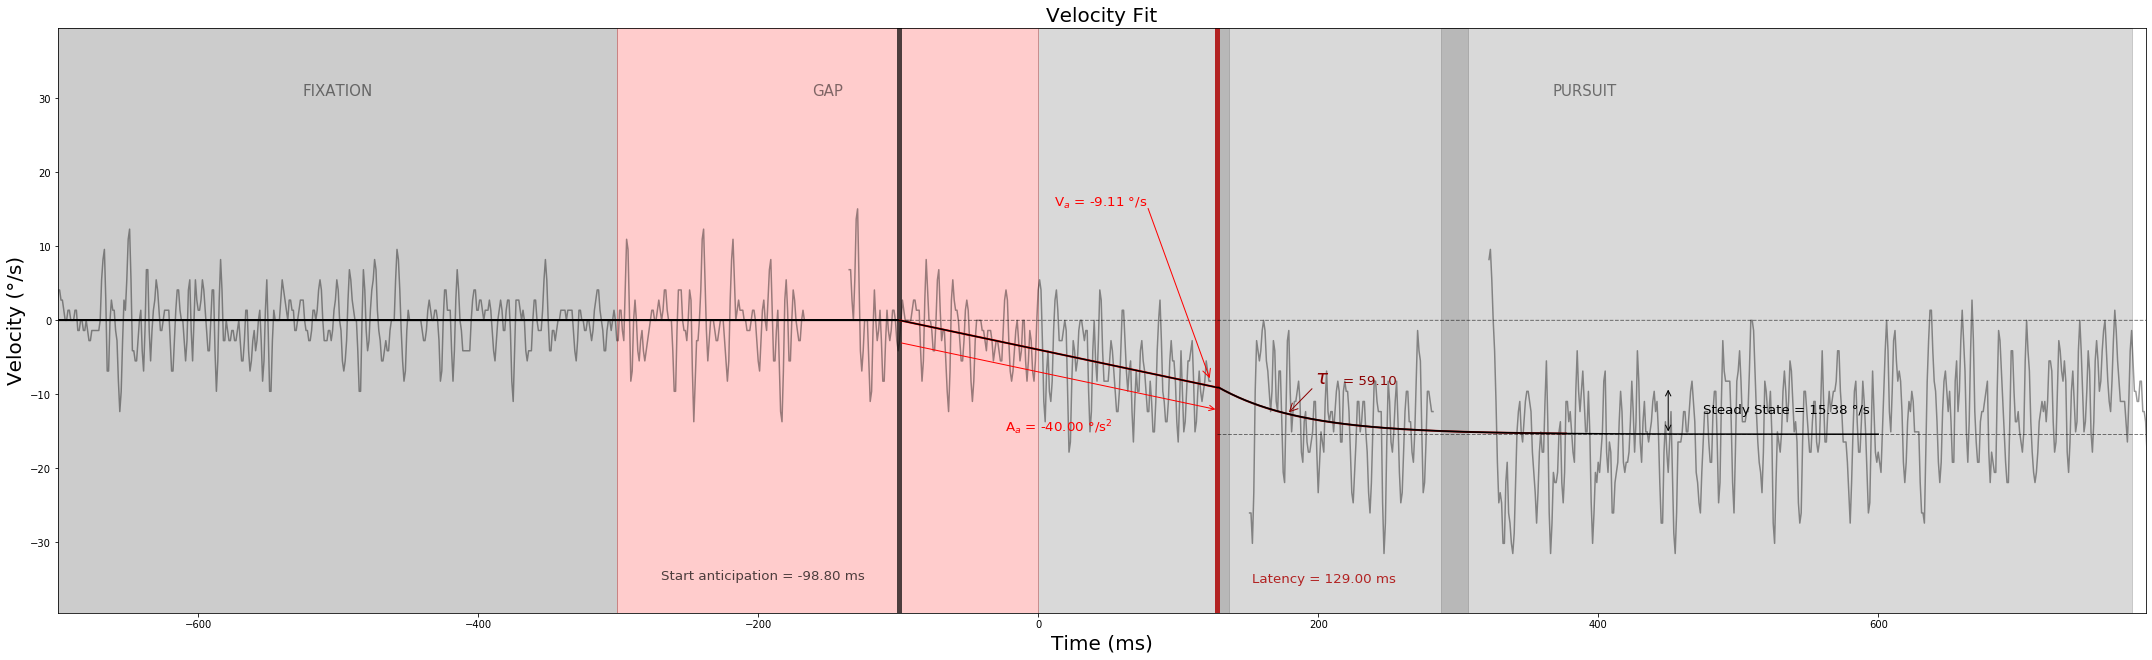

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/py

OP
trial:91


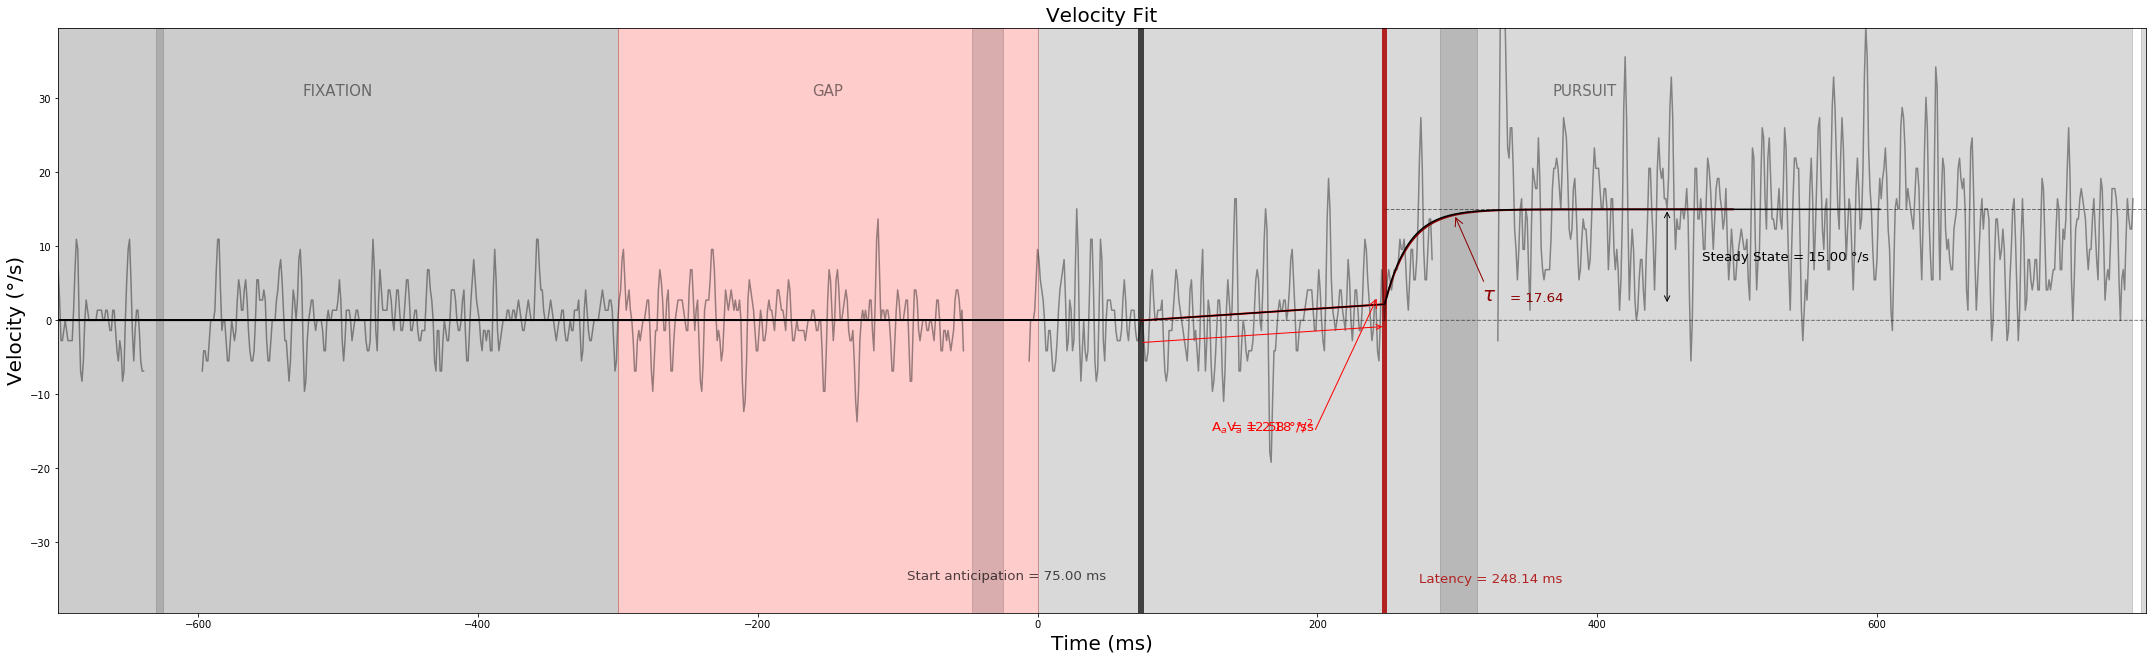

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/py

RS
trial:97


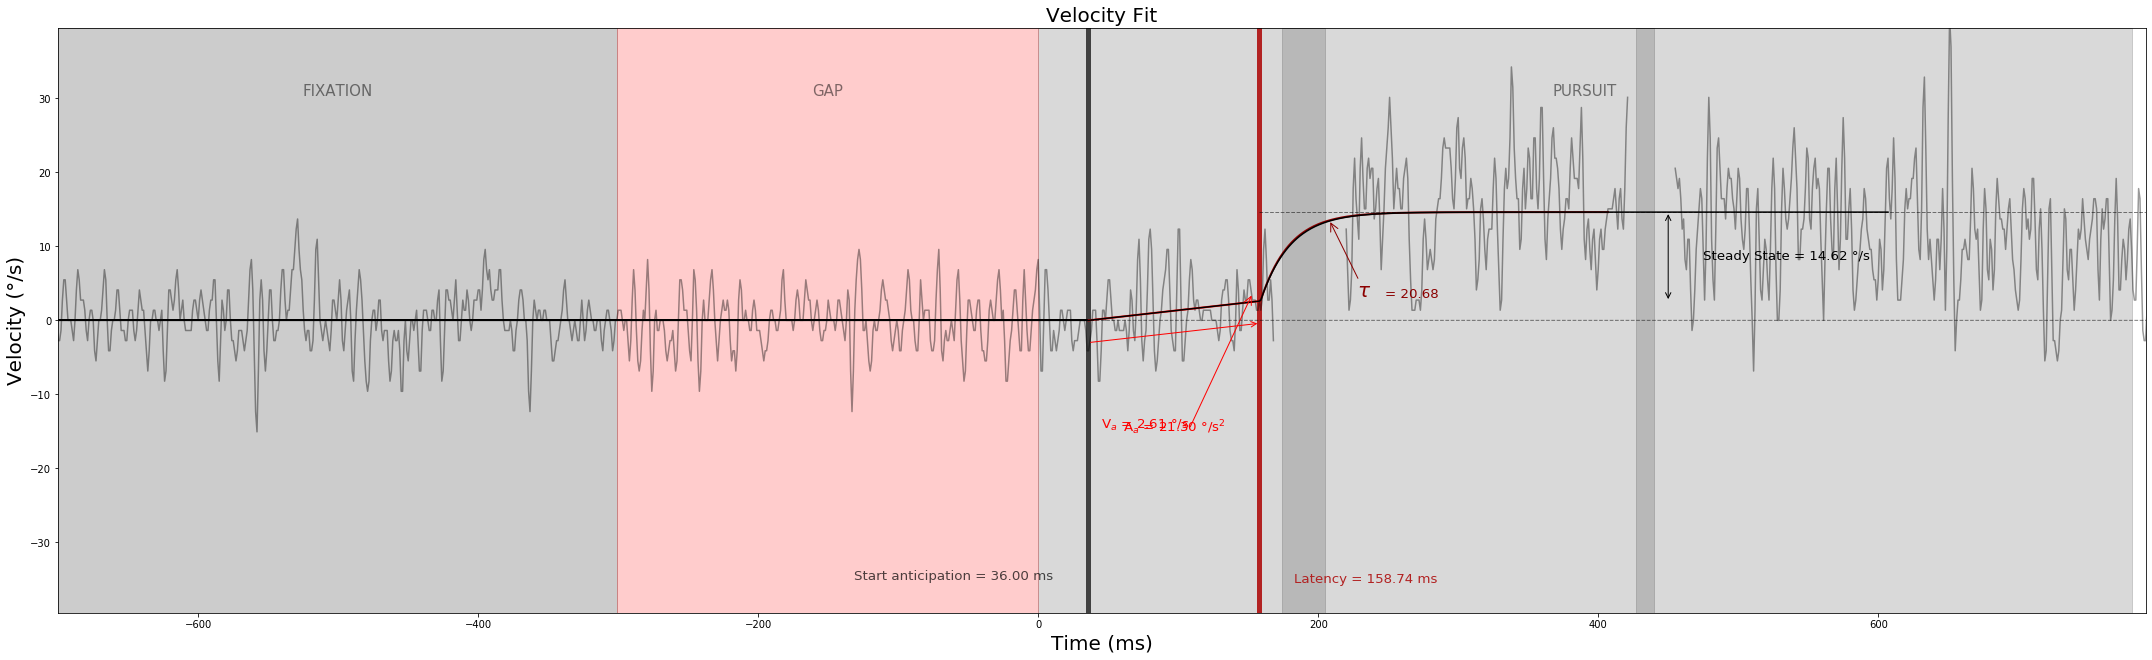

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

SR
trial:16


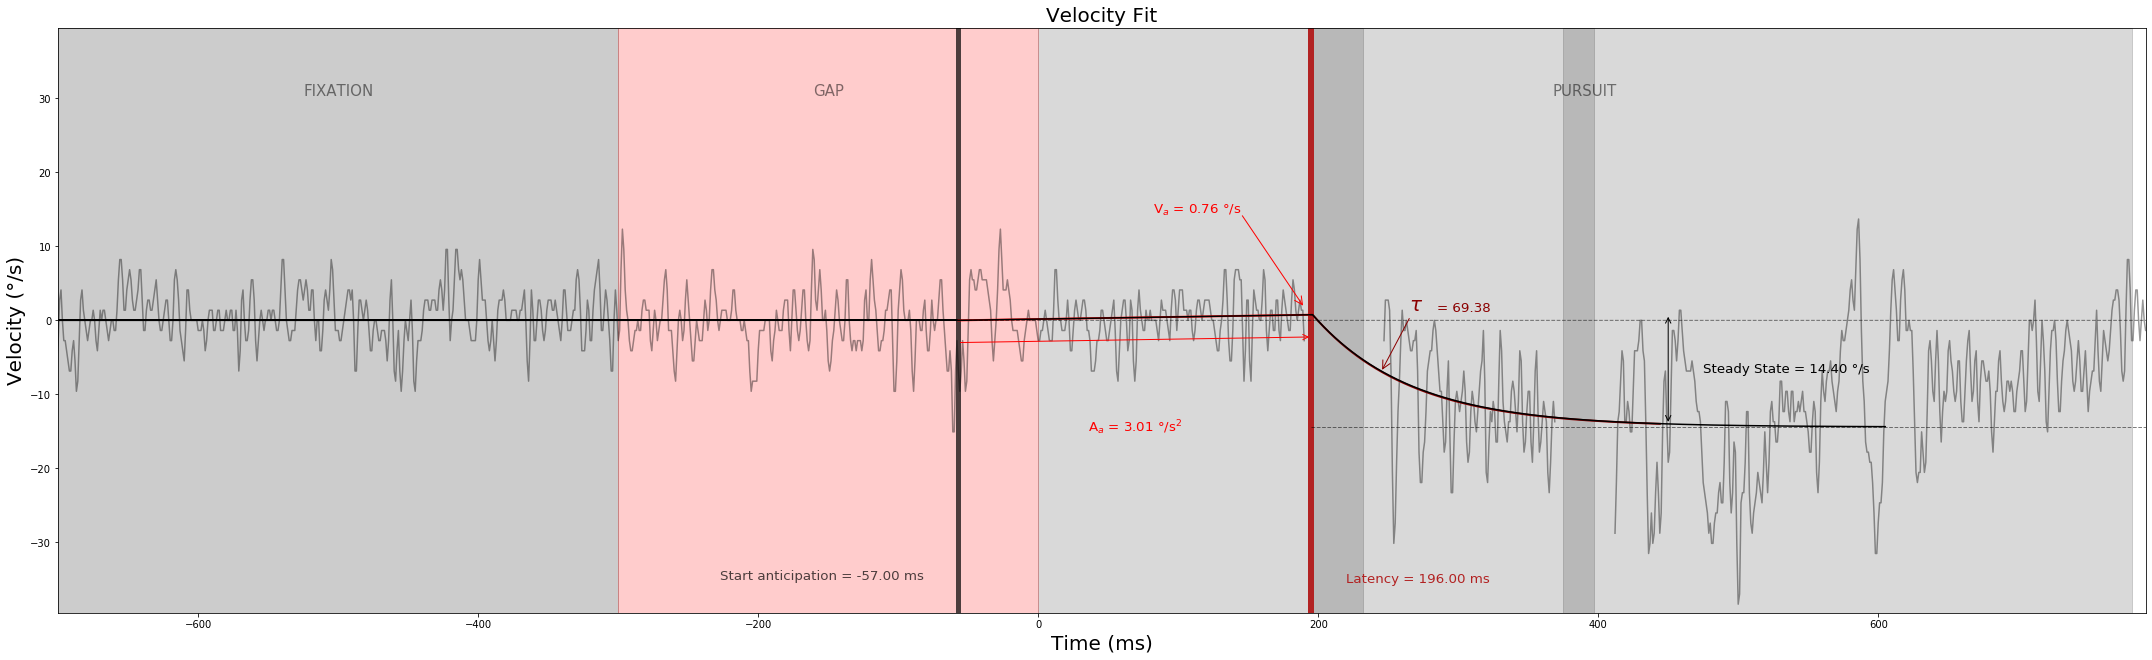

/usr/local/lib/python3.6/dist-packages/ANEMO-0.0.1-py3.6.egg/ANEMO/ANEMO.py:698: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer

TN
trial:25


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


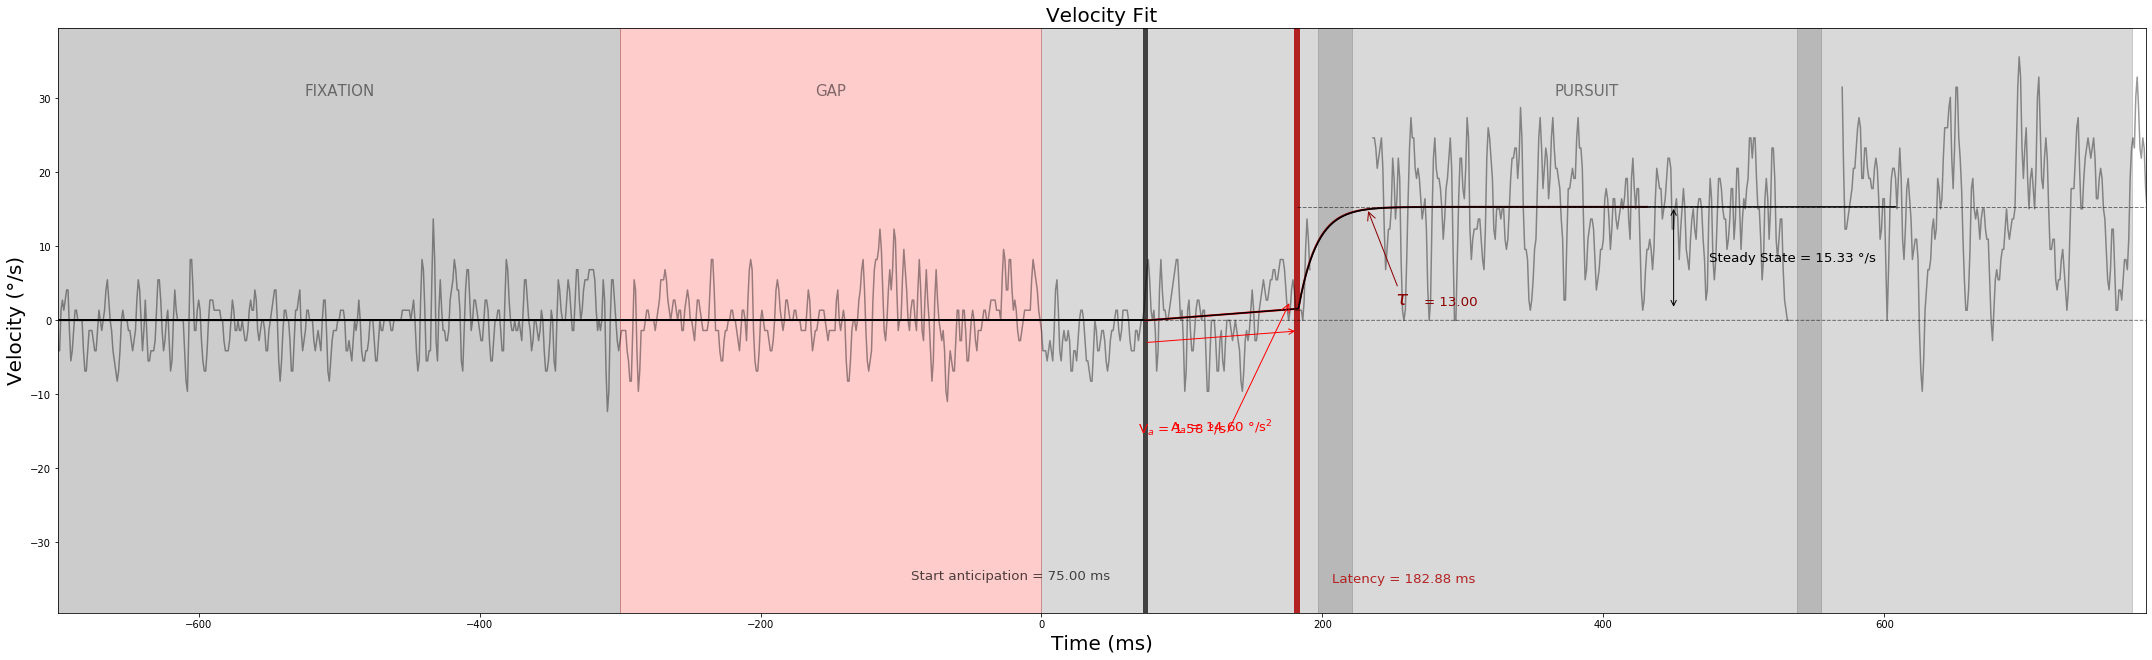

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/py

YK
trial:95


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


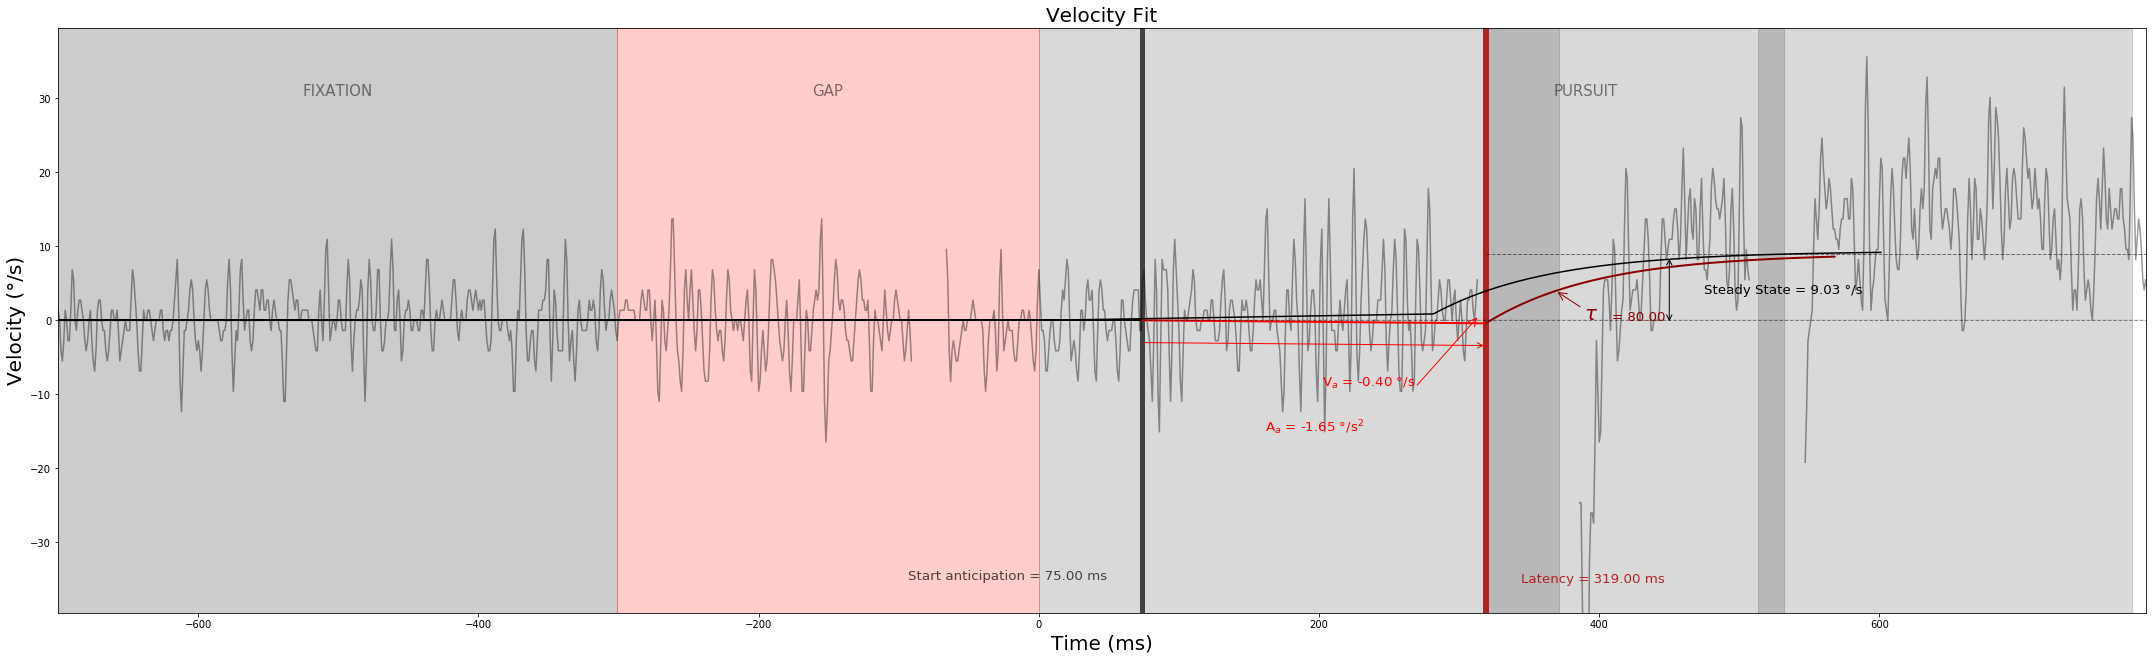

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/ANEMO-0.0.1-py3.6.egg/ANEMO/ANEMO.py:677: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/ANEMO-0.0.1-py3.6.egg/ANEMO/ANEMO.py:677: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered

In [11]:
results, results_new = [], []
for s in range(12) :
    print(sujets[s])
    t = np.random.randint(0, 200, 20)
    result_s, result_s_new = test_fit(s, t)
    results.append(result_s)
    results_new.append(result_s_new)

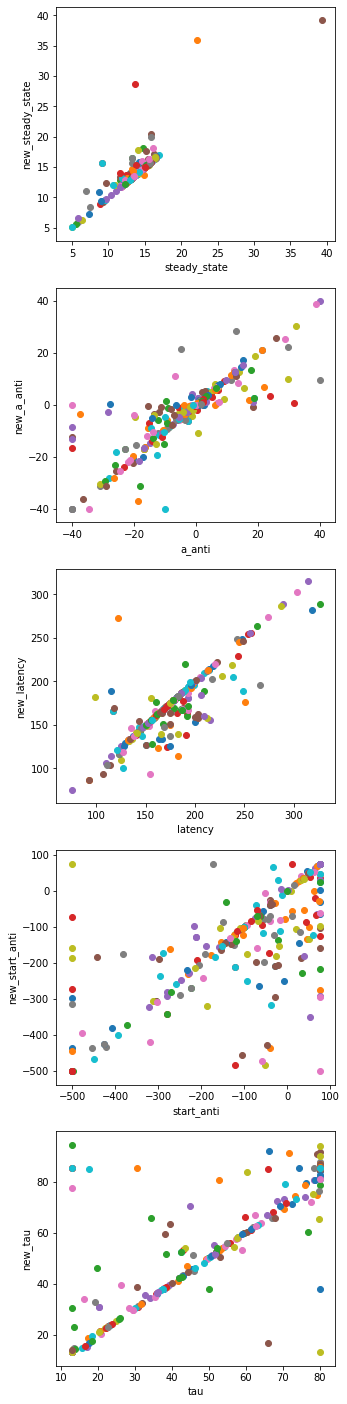

In [12]:
tau_min, tau_max = 13., 80.
max_t = 100


for s in range(len(results)) :
    for t in range(len(results[s])) :
        if s==0 and t==0 :
            nb = len(results[s][t].keys())-2
            fig, ax = plt.subplots(nb, 1, figsize=(5, 5*nb))
        i=0
        for v in results[s][t].keys() :
            if v not in ['dir_target', 'do_whitening'] :
                if v=='tau' :
                    tau_hat = results_new[s][t]['tau_hat']
                    x_, x_min, x_max = tau_hat/max_t, 0.01/max_t, (max_t-0.01)/max_t
                    tau = ( (np.log(x_/(1-x_))/(np.log(x_max/(1-x_max))-np.log(x_min/(1-x_min)))) * (tau_max-tau_min) ) + ((tau_max-tau_min)/2) + tau_min
                    ax[i].scatter(results[s][t][v], tau)
                else :
                    ax[i].scatter(results[s][t][v], results_new[s][t][v])
                if s==0 and t==0 :
                    ax[i].set_xlabel(v) ; ax[i].set_ylabel('new_%s'%v)
                i+=1

Text(0, 0.5, 'new_start_anti')

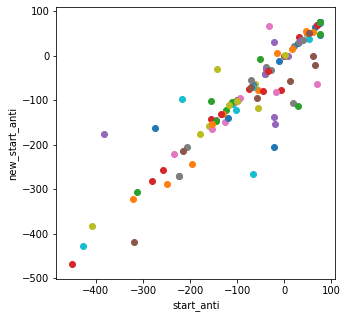

In [13]:
v = 'start_anti'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for s in range(len(results)) :
    for t in range(len(results[s])) :
        if abs(results[s][t]['a_anti']) > 5 and abs(results_new[s][t]['a_anti']) > 5 :
            ax.scatter(results[s][t][v], results_new[s][t][v])
ax.set_xlabel(v) ; ax.set_ylabel('new_%s'%v)